In [1]:
import os
os.chdir("..")
print("Current Directory:", os.getcwd())

Current Directory: d:\workspace\iscat


In [2]:
from src.data_processing.dataset import iScatDataset
from src.data_processing.utils import Utils
import torch
DEVICE= 'cuda:14' if torch.cuda.is_available() else 'cpu'
data_path = os.path.join('dataset', '2024_11_11', 'Metasurface', 'Chip_02')
image_paths,target_paths = Utils.get_data_paths(data_path)

In [3]:
image_size=256
fluo_masks_indices=[1]
train_dataset = iScatDataset(image_paths[:-1], target_paths[:-1], preload_image=True,image_size = (image_size,image_size),apply_augmentation=True,normalize=False,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method="kmeans")
valid_dataset = iScatDataset([image_paths[-1]],[target_paths[-1]],preload_image=True,image_size = (image_size,image_size),apply_augmentation=False,normalize=False,device=DEVICE,fluo_masks_indices=fluo_masks_indices,seg_method="kmeans")

Loading TIFF images to Memory: 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


In [18]:
from torch.utils.data import DataLoader, Dataset
def create_dataloaders(train_dataset, test_dataset, batch_size=4):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader
train_loader, val_loader = create_dataloaders(train_dataset, valid_dataset, batch_size=4)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from monai.losses import DiceLoss
from monai.metrics import MeanIoU
import numpy as np

# Modify the model to support multiclass segmentation
def z_score_normalize(images: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Normalize a batch of images using z-score normalization.

    Args:
        images (torch.Tensor): Input tensor of shape (N, 3, H, W), where
                               N is the batch size, 3 is the number of channels,
                               H and W are height and width.
        eps (float): A small value to avoid division by zero (default: 1e-8).

    Returns:
        torch.Tensor: Z-score normalized tensor of the same shape as `images`.
    """
    # Compute mean and std for each image in the batch
    mean = images.mean(dim=(1, 2, 3), keepdim=True)  # Shape: (N, 1, 1, 1)
    std = images.std(dim=(1, 2, 3), keepdim=True)    # Shape: (N, 1, 1, 1)

    # Perform z-score normalization
    normalized_images = (images - mean) / (std + eps)
    return normalized_images

class MultiClassUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=3, init_features=32):
        super(MultiClassUNet, self).__init__()
        
        # Load the pretrained model and modify the final layer
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                               in_channels=in_channels, 
                               out_channels=1, 
                               init_features=init_features, 
                               pretrained=True)
        
        # Replace the final convolution layer to match number of classes
        model.conv = nn.Conv2d(init_features, num_classes, kernel_size=1)
        
        self.model = model
    
    def forward(self, x):
        return self.model(x)

def calculate_metrics(predictions, targets, num_classes):
    # Convert logits to class probabilities and then to predicted classes
    predicted_classes = torch.argmax(predictions, dim=1)
    target_classes = torch.argmax(targets, dim=1)

    # Calculate accuracy
    correct = (predicted_classes == target_classes).float().sum()
    total = torch.numel(target_classes)
    accuracy = correct / total

    # Calculate mIoU
    miou_metric = MeanIoU(include_background=True, reduction="mean", ignore_empty=True)
    iou = miou_metric(predicted_classes.unsqueeze(1), target_classes.unsqueeze(1))

    # The mIoU metric might return a tensor. Reduce it to a scalar if necessary.
    if isinstance(iou, torch.Tensor) and iou.numel() > 1:
        iou = iou.mean()  # Reduce to scalar by averaging across all dimensions

    return accuracy.item(), iou.item()

def train_multiclass_segmentation(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, loss_type="cross_entropy",device=DEVICE):
    # Device configuration   
    model = model.to(device)
    
    # Select loss function
    if loss_type == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif loss_type == "dice":
        criterion = DiceLoss(include_background=True, softmax=True)
    else:
        raise ValueError("Unsupported loss type. Choose 'cross_entropy' or 'dice'.")
    
    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1)
    
    # Tensorboard for logging
    writer = SummaryWriter('runs/multiclass_segmentation')
    
    # Training loop
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_accuracy = 0.0
        train_miou = 0.0
        
        for batch_idx, (images, masks) in enumerate(train_loader):
            images = images.to(device)
            masks = masks.to(device)
            normalized_images = z_score_normalize(images)
            # Convert masks to class indices for CrossEntropyLoss
            if loss_type == "cross_entropy":
                masks = torch.argmax(masks, dim=1).long()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(normalized_images)

            # Compute loss
            loss = criterion(outputs, masks)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute metrics
            batch_accuracy, batch_miou = calculate_metrics(outputs, masks, model.model.conv.out_channels)
            train_accuracy += batch_accuracy
            train_miou += batch_miou

            # Tensorboard logging
            writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + batch_idx)

        # Average metrics for the epoch
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_miou /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        val_miou = 0.0
        with torch.no_grad():
            for images, masks in val_loader:                
                images = images.to(device)
                masks = masks.to(device)
                normalized_images = z_score_normalize(images)
                if loss_type == "cross_entropy":
                    masks = torch.argmax(masks, dim=1).long()

                outputs = model(normalized_images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Compute metrics
                batch_accuracy, batch_miou = calculate_metrics(outputs, masks, model.model.conv.out_channels)
                val_accuracy += batch_accuracy
                val_miou += batch_miou

        # Average validation metrics
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_miou /= len(val_loader)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Tensorboard logging
        writer.add_scalar('Validation Loss', val_loss, epoch)
        writer.add_scalar('Validation Accuracy', val_accuracy, epoch)
        writer.add_scalar('Validation mIoU', val_miou, epoch)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Train mIoU: {train_miou:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val mIoU: {val_miou:.4f}')

        # Model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss
            }, 'best_multiclass_unet_model.pth')
    
    writer.close()
    return model

In [20]:
num_classes = 2

# Initialize the model
model = MultiClassUNet(in_channels=3, num_classes=num_classes)

train_multiclass_segmentation(model, train_loader, val_loader, num_epochs=100, learning_rate=1e-4, loss_type='dice')

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Epoch [1/100], Train Loss: 0.8188, Train Acc: 0.6711, Train mIoU: nan, Val Loss: 0.8308, Val Acc: 0.1325, Val mIoU: nan
Epoch [2/100], Train Loss: 0.8082, Train Acc: 0.9072, Train mIoU: nan, Val Loss: 0.8139, Val Acc: 0.9675, Val mIoU: 0.0711
Epoch [3/100], Train Loss: 0.8008, Train Acc: 0.9910, Train mIoU: nan, Val Loss: 0.8035, Val Acc: 0.9849, Val mIoU: 0.1594
Epoch [4/100], Train Loss: 0.7948, Train Acc: 0.9919, Train mIoU: nan, Val Loss: 0.7910, Val Acc: 0.9882, Val mIoU: nan
Epoch [5/100], Train Loss: 0.7897, Train Acc: 0.9935, Train mIoU: nan, Val Loss: 0.7944, Val Acc: 0.9879, Val mIoU: 0.2005
Epoch [6/100], Train Loss: 0.7853, Train Acc: 0.9946, Train mIoU: nan, Val Loss: 0.7858, Val Acc: 0.9935, Val mIoU: nan
Epoch [7/100], Train Loss: 0.7813, Train Acc: 0.9953, Train mIoU: nan, Val Loss: 0.7809, Val Acc: 0.9942, Val mIoU: nan
Epoch [8/100], Train Loss: 0.7777, Train Acc: 0.9955, Train mIoU: nan, Val Loss: 0.7786, Val Acc: 0.9946, Val mIoU: 0.4669
Epoch [9/100], Train Loss: 0

MultiClassUNet(
  (model): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): 

In [24]:
while True:
    idx=0
    
    image, mask = valid_dataset[idx] 
    mask = torch.argmax(mask, dim=0).long()
    a=torch.unique(mask)
    if 1 in a:
        break

In [25]:
import matplotlib.pyplot as plt

In [26]:
model.eval()
image = image.unsqueeze(0).to(DEVICE)
image = z_score_normalize(image)
output = model(image)
output=torch.argmax(output.squeeze(0), dim=0).cpu()

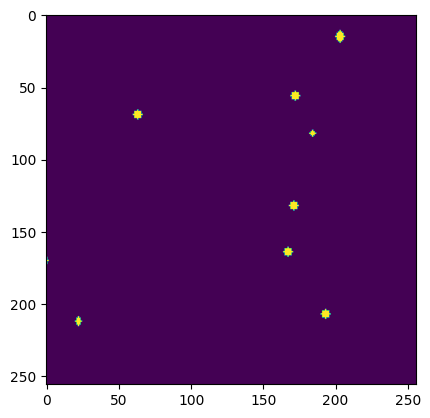

In [27]:
plt.imshow(mask.cpu().numpy())

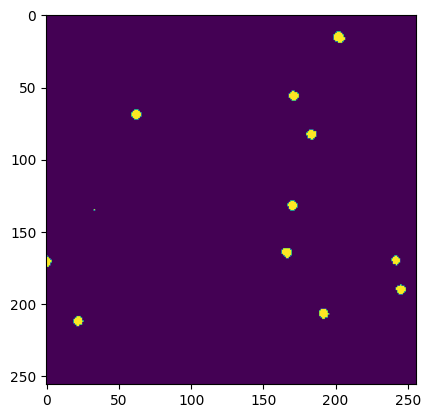

In [28]:
plt.imshow(output.numpy())

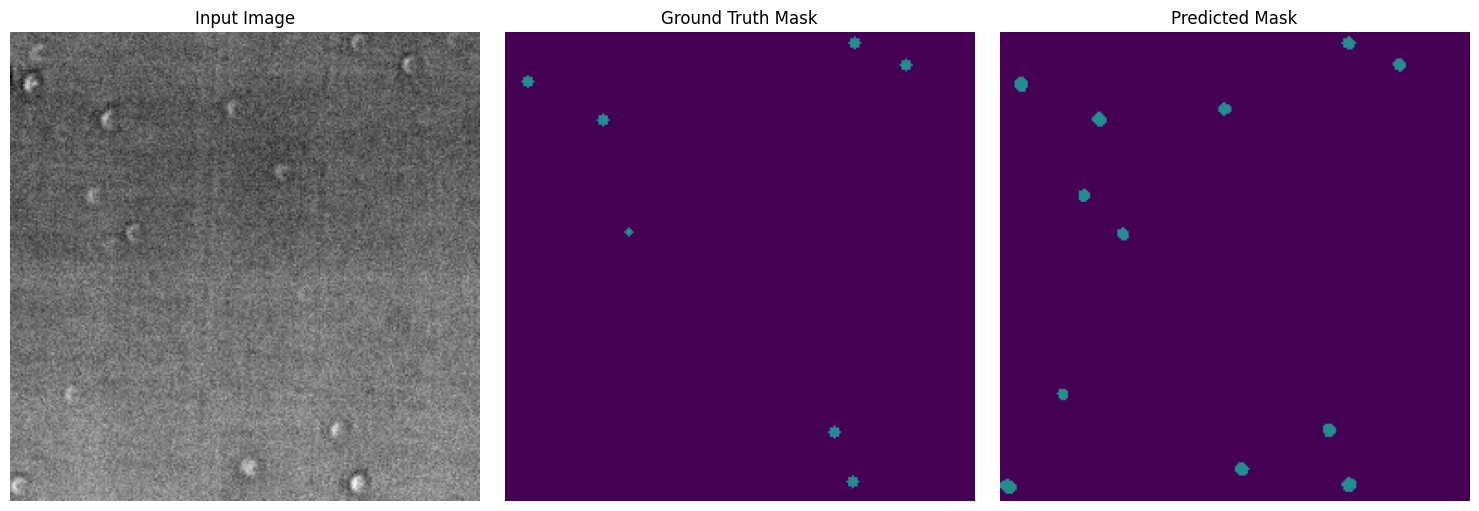

In [29]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_sample_prediction(model, dataset, device, idx=0, num_classes=3):
    """
    Plots the predicted mask and ground truth for a sample from the dataset.
    
    Args:
        model: Trained segmentation model.
        dataset: Validation dataset.
        device: Device (CPU or GPU).
        idx: Index of the sample to visualize.
        num_classes: Number of classes in the segmentation task.
    """
    # Set the model to evaluation mode
    model.eval()
    
    # Get a sample image and its ground truth mask
    image, mask = dataset[idx]  # (image: torch.Size([3, 224, 224]), mask: torch.Size([3, 224, 224]))
    
    # Add batch dimension to the image
    image = image.unsqueeze(0).to(device)  # torch.Size([1, 3, 224, 224])
    input_image = z_score_normalize(image)
    # Ground truth mask
    ground_truth_mask = torch.argmax(mask, dim=0).cpu().numpy()  # Shape: (224, 224)

    # Get the model's predicted mask
    with torch.no_grad():
        output = model(input_image)  # Shape: [1, num_classes, 224, 224]
        predicted_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # Shape: (224, 224)
    
    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    image = image.squeeze(0).cpu().numpy()
    axes[0].imshow(image[2],cmap='gray')  
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    axes[1].imshow(ground_truth_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")
    
    axes[2].imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")
    
    plt.tight_layout()
    plt.show()
    return image,predicted_mask,ground_truth_mask
# Example Usage
# Assuming model, valid_dataset, and device are already defined
image,predicted_mask,ground_truth_mask = plot_sample_prediction(model, valid_dataset, DEVICE,3)

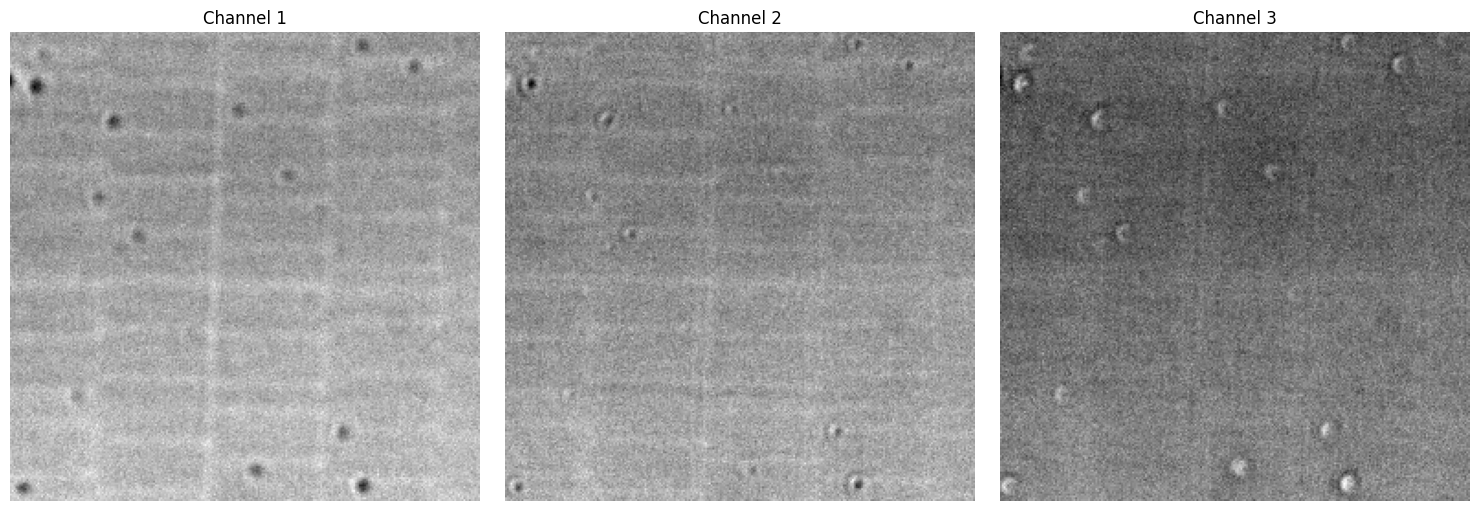

In [30]:
def plot_image_channels(image):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        ax.imshow(image[i], cmap='gray')  
        ax.set_title(f"Channel {i + 1}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()
plot_image_channels(image)

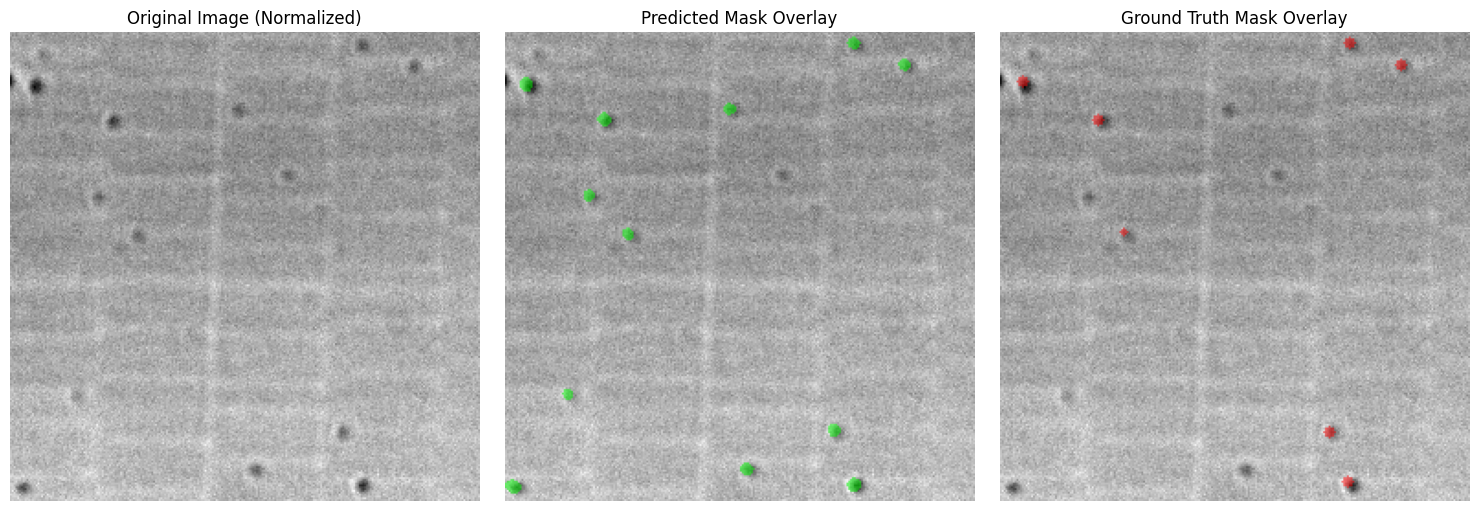

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def normalize_image(image):
    """
    Normalize a 16-bit grayscale image to 8-bit for visualization.

    Parameters:
        image (ndarray): 16-bit grayscale image.

    Returns:
        ndarray: 8-bit grayscale image.
    """
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]
    return (image * 255).astype(np.uint8)  # Scale to [0, 255]

def overlay_mask(image, mask, color, alpha=0.5):
    """
    Overlays a mask on an image with a specified color and transparency.

    Parameters:
        image (ndarray): Original image (H, W) for grayscale or (H, W, 3) for RGB.
        mask (ndarray): Binary mask (H, W).
        color (tuple): Color for the mask (R, G, B).
        alpha (float): Transparency for the overlay.

    Returns:
        ndarray: Image with mask overlay.
    """
    if len(image.shape) == 2:  # Grayscale image
        overlay = np.stack([image] * 3, axis=-1)  # Convert to RGB
    else:  # RGB image
        overlay = image.copy()

    for c in range(3):  # Apply the mask color
        overlay[:, :, c] = np.where(mask, 
                                    overlay[:, :, c] * (1 - alpha) + color[c] * alpha, 
                                    overlay[:, :, c])
    return overlay

def plot_image_with_masks(image, predicted_mask, ground_truth_mask, output_path="output.png"):
    # Normalize the 16-bit grayscale image to 8-bit
    image_normalized = normalize_image(image)

    # Ensure masks are boolean
    predicted_mask = predicted_mask.astype(bool)
    ground_truth_mask = ground_truth_mask.astype(bool)

    # Overlay masks with distinct colors
    predicted_overlay = overlay_mask(image_normalized, predicted_mask, color=(0, 255, 0), alpha=0.5)  # Green
    gt_overlay = overlay_mask(image_normalized, ground_truth_mask, color=(255, 0, 0), alpha=0.5)  # Red

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image_normalized, cmap='gray')
    axs[0].set_title("Original Image (Normalized)")
    axs[0].axis("off")

    axs[1].imshow(predicted_overlay)
    axs[1].set_title("Predicted Mask Overlay")
    axs[1].axis("off")

    axs[2].imshow(gt_overlay)
    axs[2].set_title("Ground Truth Mask Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight') 
    plt.show()



plot_image_with_masks(image[0], predicted_mask, ground_truth_mask, output_path="plot_with_masks_5.png")
